In [1]:
import re
from pathlib import Path
import os
from datetime import datetime
import geopandas as gpd
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
import rasterio
import numpy as np
from tqdm import tqdm

# Processamento com Código Atual

In [2]:
def read_tif_files(S2_tile,tiles):
        # DGT
    DGT=False
    # outro
    # Theia_T29TNE_20171007-112058

    list_files=[]
    for i in range(2017, 2024):
        if DGT: 
            if i == 2017:
                base_folder = fr"\\192.168.10.35\\Imag_sentinel2\\Theia_S2process\\" + S2_tile
            else:
                base_folder = fr"\\192.168.10.35\\Imag_sentinel2\\Theia_S2process_" + str(i + 1) + "\\" + S2_tile
            tiff_pattern = fr"{base_folder}\\S2*.tif"
        else:
            base_folder=tiles
            #print('base_folder',base_folder)
            tiff_pattern=re.compile('^Theia_T29TNE_' + re.escape(str(i)) + '.*tif$')

        tiff_files1=[]
        for root, dirs, files in os.walk(base_folder):
            for file in files:
                if tiff_pattern.match(file):
                    tiff_files1.append(file)
        
        # Ordena os arquivos pela data
        tiff_files = sorted(tiff_files1) #, key=extract_date)
        list_files.extend(tiff_files)


    if DGT:
        dates = []
        date_pattern = re.compile(r"S2A_L2A_(\d{8})-\d{6}_"+S2_tile+".tif")
        date_pattern2 = re.compile(r"S2B_L2A_(\d{8})-\d{6}_"+S2_tile+".tif")
        for tiff_file in tiff_files:
            match = date_pattern.search(tiff_file)
            match1 = date_pattern2.search(tiff_file)
            if match:
                date = match.group(1)
                dates.append(date)
            if match1:
                date = match1.group(1)
                dates.append(date)
    else:
        L=len('Theia_T29TNE_')
        dates= [x[L:(L+8)] for x in list_files]

    date_objects = [datetime.strptime(date, '%Y%m%d').date() for date in dates]
    return list_files, date_objects

In [3]:
def processar_ponto(args):
    k, ponto_desejado, S2_tile, tiles = args
    #print('module path', module_path)
    #print('S2_tile',S2_tile)
    #base_folder=module_path / S2_tile
    bandas_desejadas = [1, 2, 3, 7, 9, 10]

    tiff_files,date_objects = read_tif_files(S2_tile, tiles)

    #print(tiff_files)

    query_bands = []
    for j, tiff_path in enumerate(tiff_files):
        numero_ordinal = date_objects[j].toordinal()

        #with rasterio.open(os.path.join(module_path,S2_tile,tiff_path)) as src:
        with rasterio.open(str(tiles / tiff_path)) as src:
            valores_ponto_desejado = [banda for banda in src.sample([(ponto_desejado.x, ponto_desejado.y)], indexes=bandas_desejadas)]

            linha_pixeis1 = np.concatenate(valores_ponto_desejado).tolist()
            
            linha_pixeis = [numero_ordinal] + linha_pixeis1

            query_bands.append(linha_pixeis)
        src.close()
    
    df1 = pd.DataFrame(query_bands)
    #df2 = df1[~(df1 == NODATA_VALUE).any(axis=1)].reset_index(drop=True)
    #df3 = df2.transpose()
    df3 = pd.DataFrame(df1)

    #dates, blues, greens, reds, nirs, swir1s, swir2s = df3.values
    return df3.values

In [3]:
base_path= Path(__name__ ).parent.absolute()
S2_tile = 'T29TNE'
tiles = base_path / 'Dev_pyccd_ISA/S2CHANGE/scripts' / 'pyccd_theia' / S2_tile
caminho_arquivo = '/media/daniel/7C42A09342A05424/Users/morae/Desktop/PhD_NovaIMS/Paper 3/Experimentos_pyccd/Dev_pyccd_ISA/S2CHANGE/scripts/pyccd_theia/T29TNE/BUFFER_300/pontos_300_buffers_1_UTM.gpkg'
N = 10000

In [4]:
dados_geoespaciais_metros = gpd.read_file(caminho_arquivo)
dados_geoespaciais_metros = dados_geoespaciais_metros.sample(N, random_state=42).copy()

In [13]:
%%time
dfs = []
with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
    tqdm_bar = tqdm(total=N)
    args_list = [(k, dados_geoespaciais_metros.iloc[k].geometry, S2_tile, tiles) for k in range(N)]
    
    for result_df in executor.map(processar_ponto, args_list):
        dfs.append(result_df)
        tqdm_bar.update(1)

100%|█████████████████████████████████████▉| 9999/10000 [33:57<00:00,  7.69it/s]

CPU times: user 7.59 s, sys: 2.28 s, total: 9.87 s
Wall time: 33min 57s


100%|█████████████████████████████████████| 10000/10000 [34:10<00:00,  7.69it/s]

# Processamento com XArray

## Introdução ao XArray e Dask

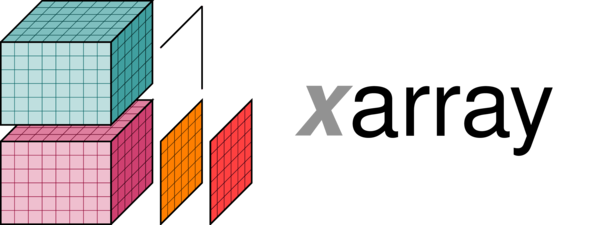
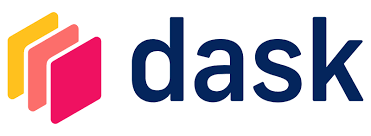

### XArray
<br>

<font size="3">
"XArray is an open source project and Python package that extends the labeled data functionality of Pandas to N-dimensional array-like datasets. It shares a similar API to NumPy and Pandas and supports both Dask and NumPy arrays under the hood."

Em resumo:
* É um package adequado para trabalhar com dados multidimensionais (e.g. série multitemporal, multibanda de imagens)
* Usa como base o Dask, que permite que se parta as arrays em chunks, facilitando caber na memória e paralelizar
* Dá nomes (labels) às dimensões, coordenadas e atributos advindos de numpy arrays
* * Exemplo: x, y, lat, lon, time, band
* Os nomes (labels) facilitam o processamento - tornam mais intuitivo
* * Exemplo: x.sum('time') -> aplica a função de soma sobre a dimensão 'time'
</font>

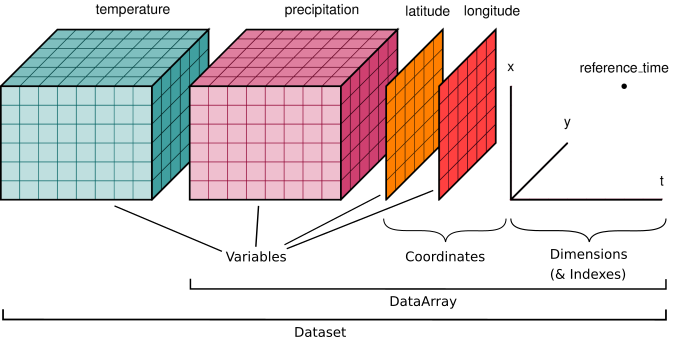

### Dask
<br>

<font size="3">
"Dask is a Python library for parallel and distributed computing."

* É uma solução adequada para contornar problemas que resultam em out of core ou out of memory
* Consegue partir as tarefas em chunks - para fazer caber na memória e para paralelizar/distribuir
* É baseada num paradigma de lazy evaluation/computing
* * O resultado de uma computação não é computado até que se peça que o seja
* * São apenas criadas instruções, através de um task graph
* * Para computar o resultado, usa-se tipicamente a função compute()
</font>

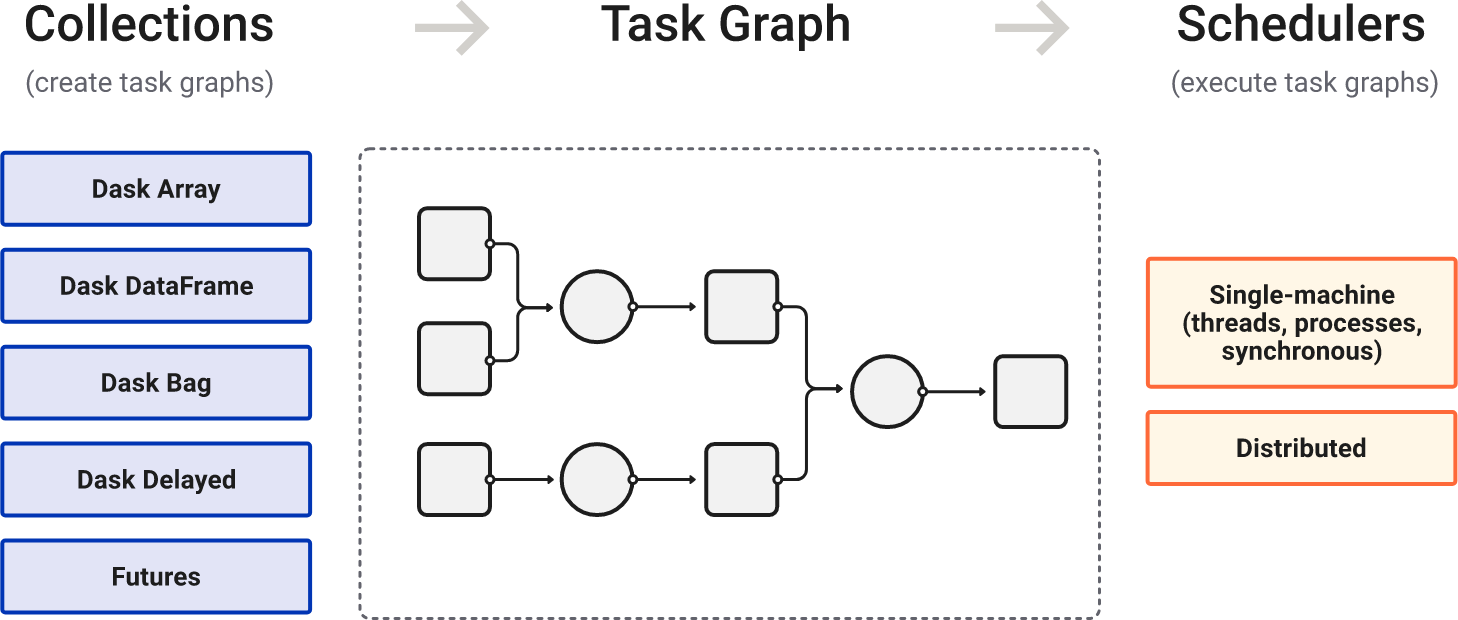

## Exemplo prático: Processamento dados Theia

In [6]:
import xarray as xr
import rioxarray #integra xarray com rasterio

In [7]:
#get tif names and date
tif_names, tif_dates = read_tif_files(S2_tile,tiles)
#add full path to tif names
tif_names = [os.path.join(tiles,i) for i in tif_names]
#convert dates to ordinal
tif_dates_ord = [d.toordinal() for d in tif_dates]

In [8]:
bandas_desejadas = [1, 2, 3, 7, 9, 10]
# 1- blue
# 2- green
# 3- red
# 4- vre 1
# 5- vre 2
# 6- vre 3
# 7- nir
# 8- vre 4
# 9- swir1
# 10- swir2

### Using x=100, y=100 chunks

Enables faster querying on specific/limited location

In [9]:
#read with xarray (rioxarray - rasterio integrated to xarray)
# Create variable used for time axis
time_var = xr.Variable('time',tif_dates_ord)
# Load in and concatenate all individual GeoTIFFs
tifs_xr = [rioxarray.open_rasterio(i, chunks={'x':100, 'y':100}) for i in tif_names] #did not work without using chunks (maybe something related to lock)
geotiffs_da = xr.concat(tifs_xr, dim=time_var)


In [9]:
geotiffs_da.sel(band=bandas_desejadas)

<xarray.DataArray (time: 444, band: 6, y: 10900, x: 10924)>
dask.array<getitem, shape=(444, 6, 10900, 10924), dtype=uint16, chunksize=(1, 6, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3 7 9 10
  * x            (x) float64 5.005e+05 5.005e+05 ... 6.097e+05 6.097e+05
  * y            (y) float64 4.5e+06 4.5e+06 4.5e+06 ... 4.391e+06 4.391e+06
    spatial_ref  int64 0
  * time         (time) int64 736604 736604 736607 ... 738787 738789 738792
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     65535
    scale_factor:   1.0
    add_offset:     0.0

In [10]:
geotiffs_da.sel(x=500495, y=4499705, band=bandas_desejadas)

<xarray.DataArray (time: 444, band: 6)>
dask.array<getitem, shape=(444, 6), dtype=uint16, chunksize=(1, 6), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3 7 9 10
    x            float64 5.005e+05
    y            float64 4.5e+06
    spatial_ref  int64 0
  * time         (time) int64 736604 736604 736607 ... 738787 738789 738792
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     65535
    scale_factor:   1.0
    add_offset:     0.0

In [11]:
geotiffs_da.sel(x=541615, y=4444555, band=bandas_desejadas).values

array([[65535, 65535, 65535, 65535, 65535, 65535],
       [  190,   349,   270,  1652,   934,   414],
       [  200,   305,   251,  1615,   812,   367],
       ...,
       [  307,   368,   384,  1896,  1439,   746],
       [  257,   346,   405,  1887,  1543,   807],
       [  217,   311,   371,  1787,  1427,   682]], dtype=uint16)

In [13]:
geotiffs_da.sel(x=541615, y=4444555, band=bandas_desejadas).mean('time').compute().values

array([14439.08108108, 14554.92567568, 14647.12837838, 15629.42342342,
       15574.35585586, 15015.07207207])

Example of what Dask is doing under the hood when computing the mean


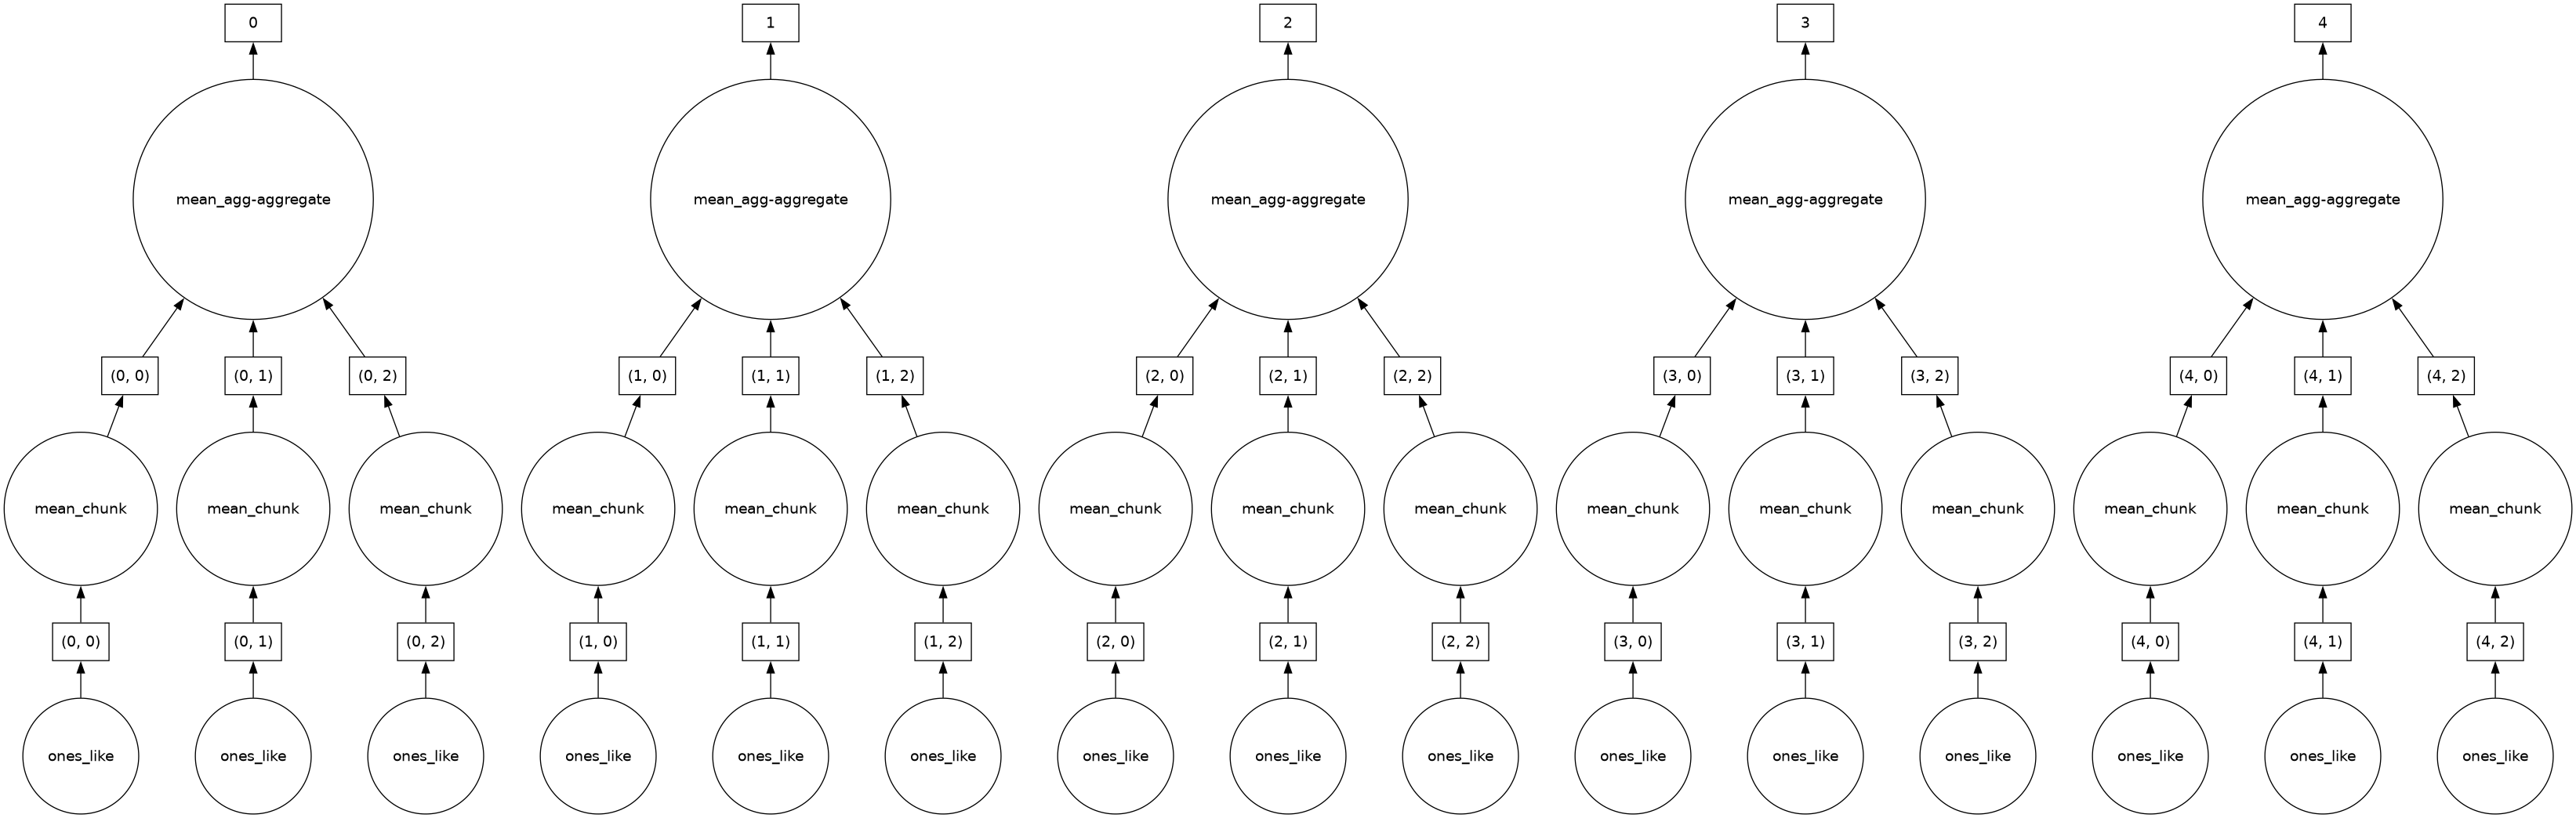

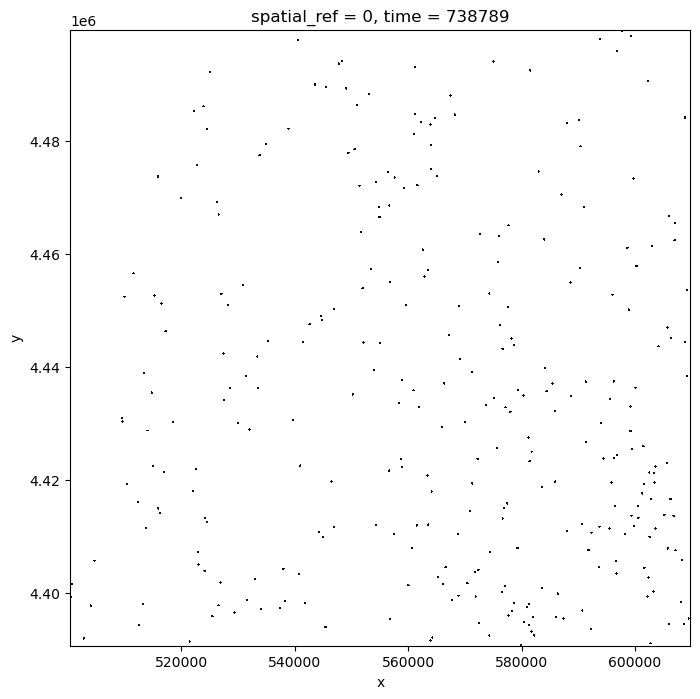

In [11]:
geotiffs_da.sel(time=738789, band=[1,2,3]).plot.imshow(vmin=0, vmax=10000,figsize=(8,8))

### Using a whole tif as the chunk

Seems more appropriate for doing computations in regions throughout the whole area of the raster 

In [14]:
#read with xarray (rioxarray - rasterio integrated to xarray)
# Create variable used for time axis
time_var = xr.Variable('time',tif_dates_ord)
# Load in and concatenate all individual GeoTIFFs
tifs_xr = [rioxarray.open_rasterio(i, chunks={'x':10924, 'y':10900}) for i in tif_names] #did not work without using chunks (maybe something related to lock)
geotiffs_da = xr.concat(tifs_xr, dim=time_var)


In [15]:
geotiffs_da.sel(band=bandas_desejadas)

/home/daniel/anaconda3/envs/xarr_env/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.DataArray (time: 444, band: 6, y: 10900, x: 10924)>
dask.array<getitem, shape=(444, 6, 10900, 10924), dtype=uint16, chunksize=(1, 6, 10900, 10924), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3 7 9 10
  * x            (x) float64 5.005e+05 5.005e+05 ... 6.097e+05 6.097e+05
  * y            (y) float64 4.5e+06 4.5e+06 4.5e+06 ... 4.391e+06 4.391e+06
    spatial_ref  int64 0
  * time         (time) int64 736604 736604 736607 ... 738787 738789 738792
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     65535
    scale_factor:   1.0
    add_offset:     0.0

In [16]:
#get points x and y coordinates
points_x_int = xr.DataArray(np.round(dados_geoespaciais_metros.geometry.x.values).astype('int'), dims=['location'])
points_y_int = xr.DataArray(np.round(dados_geoespaciais_metros.geometry.y.values).astype('int'), dims=['location'])

In [17]:
#sample tif stack at point locations
selection = geotiffs_da.sel(x=points_x_int, y=points_y_int, band=bandas_desejadas)

In [18]:
selection

<xarray.DataArray (time: 444, band: 6, location: 10000)>
dask.array<transpose, shape=(444, 6, 10000), dtype=uint16, chunksize=(1, 6, 10000), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3 7 9 10
    x            (location) float64 5.1e+05 5.2e+05 ... 5.331e+05 5.266e+05
    y            (location) float64 4.452e+06 4.47e+06 ... 4.402e+06 4.398e+06
    spatial_ref  int64 0
  * time         (time) int64 736604 736604 736607 ... 738787 738789 738792
Dimensions without coordinates: location
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     65535
    scale_factor:   1.0
    add_offset:     0.0

In [21]:
selection.x.data.shape

(10000,)

In [23]:
%%time
sel_values = selection.values

CPU times: user 9min 34s, sys: 1min 49s, total: 11min 23s
Wall time: 10min 51s


In [230]:
result_xr = np.append(sel_values,np.repeat(selection.time.values,sel_values.shape[-1]).reshape(sel_values.shape[0],1,sel_values.shape[-1]),axis=1)
result_xr = np.roll(np.transpose(result_xr,axes=(2,0,1)),1,axis=2)

In [231]:
result_xr.shape

(10000, 444, 7)

In [233]:
result_xr[0][1]

array([736604,    233,    377,    302,   1717,    853,    406])

In [234]:
dfs[0][1]

array([736604,    233,    377,    302,   1717,    853,    406])